In [8]:
import numpy as np
import pandas as pd
from vtl.Readfile import Readfile
from spec_id import RT_spec,Gen_spec, Analyze_LH,Median_w_Error_cont,Leave_one_out
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13, z_at_value
from astropy.table import Table
from astropy.io import fits
import astropy
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126')

In [11]:
"""DATA"""

def Bootstrap_errors_lfit(masses,metals,ers,sampling=np.arange(10,11.75,.01),its=1000):
    l_grid = np.zeros([its,len(sampling)])
    IDs = np.arange(len(masses))
    for i in range(its):
        IDn = np.random.choice(IDs,len(IDs),replace=True)
        lvals = np.polyfit(masses[IDn],np.log10(metals[IDn]/.019),1,w = 1/ers[IDn]**2)
        lfit = np.polyval(lvals,sampling)
        l_grid[i] = lfit
        
    m_fit = np.mean(l_grid,axis=0)
    low_ers = np.zeros(len(samp))
    hi_ers = np.zeros(len(samp))
    
    for i in range(len(l_grid.T)):
        low_ers[i] = np.sort(l_grid.T[i])[150]
        hi_ers[i] = np.sort(l_grid.T[i])[830]
    return low_ers,hi_ers, m_fit

Pl_grid,Pm_grid,Ph_grid,Puh_grid = [[],[],[],[]]
for i in lzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % lzDB['gids'][i])
    Pl_grid.append(Px)
 
for i in mzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % mzDB['gids'][i])
    Pm_grid.append(Px)

for i in hzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % hzDB['gids'][i])
    Ph_grid.append(Px)

for i in uhzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % uhzDB['gids'][i])
    Puh_grid.append(Px)

Pl_grid = np.array(Pl_grid)
Pm_grid = np.array(Pm_grid)
Ph_grid = np.array(Ph_grid)
Puh_grid = np.array(Puh_grid)

W = Leave_one_out(Pl_grid,metal)
top = np.zeros(Pl_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Pl_grid[i]
Pl =sum(top)/sum(W)
Pl /= np.trapz(Pl,metal)

W = Leave_one_out(Pm_grid,metal)
top = np.zeros(Pm_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Pm_grid[i]
Pm =sum(top)/sum(W)
Pm /= np.trapz(Pm,metal)

W = Leave_one_out(Ph_grid,metal)
top = np.zeros(Ph_grid.shape)
for i in range(W.size):
    
    top[i] = W[i] * Ph_grid[i]
Ph =sum(top)/sum(W)
Ph /= np.trapz(Ph,metal)

W = Leave_one_out(Puh_grid,metal)
top = np.zeros(Puh_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Puh_grid[i]
Puh =sum(top)/sum(W)
Puh /= np.trapz(Puh,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
errs = (gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa']/2) / (gmtlDB['Zx_lwa'] * np.log(10))
lvals,cov = np.polyfit(gmtlDB['lmass'],np.log10(gmtlZ/.019),1,w = 1/errs**2,cov=True)
lfit = np.polyval(lvals,np.arange(10,11.75,.01))

samp = np.arange(10,11.75,.01)
low_ers,hi_ers,m_fit = Bootstrap_errors_lfit(gmtlDB['lmass'].values,gmtlZ,errs.values,sampling=samp)

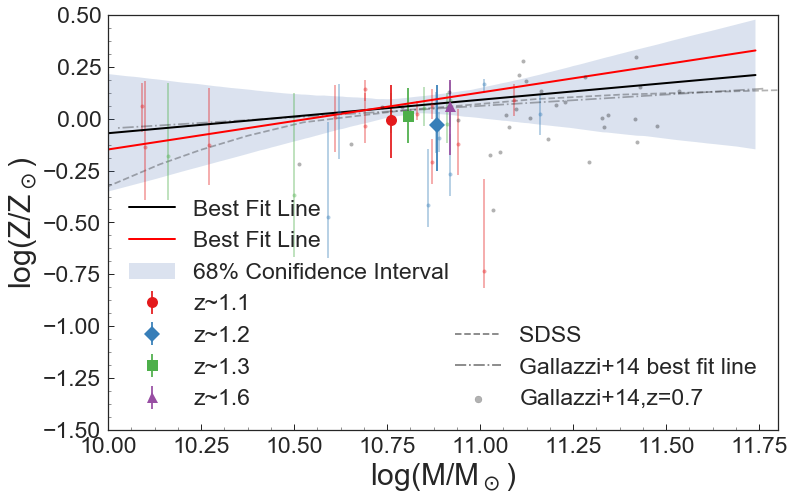

In [15]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=23)
currentAxis.add_artist(legend1)
#####single galaxy points

plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_dt']/(lzDB['Zx_dt'] * np.log(10)),lzDB['Zx_+_sig_dt']/(lzDB['Zx_dt'] * np.log(10))]
             ,color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_dt']/(mzDB['Zx_dt'] * np.log(10)),mzDB['Zx_+_sig_dt']/(mzDB['Zx_dt'] * np.log(10))]
             ,color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_dt']/(hzDB['Zx_dt'] * np.log(10)),hzDB['Zx_+_sig_dt']/(hzDB['Zx_dt'] * np.log(10))]
             ,color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.plot(samp,m_fit,'k',linewidth=2,label ='Best Fit Line')
plt.plot(samp,lfit,'r',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_10-17.pdf',bbox_inches = 'tight')
plt.close()

In [18]:
print cov

[[ 0.01569155 -0.17108761]
 [-0.17108761  1.86565527]]


In [23]:
np.sqrt(cov[0][0]+cov[1][1]*samp**2+2*samp*cov[0,1]*cov[0][0]*cov[1][1])

array([ 13.65580633,  13.66946466,  13.68312299,  13.69678131,
        13.71043964,  13.72409797,  13.7377563 ,  13.75141464,
        13.76507297,  13.7787313 ,  13.79238964,  13.80604798,
        13.81970631,  13.83336465,  13.84702299,  13.86068134,
        13.87433968,  13.88799802,  13.90165637,  13.91531471,
        13.92897306,  13.94263141,  13.95628975,  13.9699481 ,
        13.98360646,  13.99726481,  14.01092316,  14.02458152,
        14.03823987,  14.05189823,  14.06555658,  14.07921494,
        14.0928733 ,  14.10653166,  14.12019002,  14.13384839,
        14.14750675,  14.16116512,  14.17482348,  14.18848185,
        14.20214022,  14.21579859,  14.22945696,  14.24311533,
        14.2567737 ,  14.27043207,  14.28409044,  14.29774882,
        14.3114072 ,  14.32506557,  14.33872395,  14.35238233,
        14.36604071,  14.37969909,  14.39335747,  14.40701585,
        14.42067424,  14.43433262,  14.44799101,  14.4616494 ,
        14.47530778,  14.48896617,  14.50262456,  14.51

In [24]:
lfit

array([ -1.47921513e-01,  -1.45178395e-01,  -1.42435278e-01,
        -1.39692161e-01,  -1.36949043e-01,  -1.34205926e-01,
        -1.31462809e-01,  -1.28719691e-01,  -1.25976574e-01,
        -1.23233457e-01,  -1.20490339e-01,  -1.17747222e-01,
        -1.15004105e-01,  -1.12260987e-01,  -1.09517870e-01,
        -1.06774752e-01,  -1.04031635e-01,  -1.01288518e-01,
        -9.85454004e-02,  -9.58022830e-02,  -9.30591656e-02,
        -9.03160483e-02,  -8.75729309e-02,  -8.48298136e-02,
        -8.20866962e-02,  -7.93435788e-02,  -7.66004615e-02,
        -7.38573441e-02,  -7.11142268e-02,  -6.83711094e-02,
        -6.56279920e-02,  -6.28848747e-02,  -6.01417573e-02,
        -5.73986400e-02,  -5.46555226e-02,  -5.19124052e-02,
        -4.91692879e-02,  -4.64261705e-02,  -4.36830532e-02,
        -4.09399358e-02,  -3.81968184e-02,  -3.54537011e-02,
        -3.27105837e-02,  -2.99674664e-02,  -2.72243490e-02,
        -2.44812316e-02,  -2.17381143e-02,  -1.89949969e-02,
        -1.62518796e-02,